<a href="https://colab.research.google.com/github/naldo14/tesis-/blob/main/filtro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import sys
import h5py #librerua para crear archivos , h5py

In [22]:
#hacer el mounted de mi cuenta drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks")
import unzipmodule
import graficador

In [24]:
def print_h5py_keys(file_path):
    with h5py.File(file_path, 'r') as h5_file:
        print("Keys in the h5py file:")
        for key in h5_file.keys():
            print(key)

In [9]:
#### creo una clase asociada al filtro pasa bajo
class low_band_filter:
  def __init__(self, siganl_1,N, cutoff,sampling_frecuencie):
    self.signal_1=signal_1
    self.order=N
    self.cutoff=cutoff
    self.sampling_frecuencie=sampling_frecuencie
    self.sos = None  # Initialize sos as None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    b, a = signal.butter(self.order,self.cutoff/fnqy, 'low', True) #coeficientes de la funcion de transferencia
    w, h = signal.freqs(b, a)
    self.sos = signal.butter(self.order, self.cutoff/fnqy, analog=False, btype='low', output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)


#### creo una clase asociada al filtro pasa banda
class pass_band_filter:
  def __init__(self, siganl_1,wp,ws,sampling_frecuencie):
    self.signal_1=signal_1
    self.wp=wp
    self.ws=ws
    self.sampling_frecuencie=sampling_frecuencie
    self.sof=None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    N, Wn = signal.buttord([self.wp[0]/fnqy,self.wp[1]/fnqy], [self.ws[0]/fnqy, self.ws[1]/fnqy], 3, 40, True)
    b, a = signal.butter(N, Wn, 'bandpass', True)
    w, h = signal.freqs(b, a)
    self.sos=signal.butter(N, Wn,  analog=False, btype='bandpass', output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)

#### creo una clase asociada al filtro pasa banda
class stop_band_filter:
  def __init__(self, siganl_1,wp,ws,sampling_frecuencie):
    self.signal_1=signal_1
    self.wp=wp
    self.ws=ws
    self.sampling_frecuencie=sampling_frecuencie
    self.sof=None

  def filter_making(self):
    fnqy=self.sampling_frecuencie/2
    N, Wn = signal.buttord([self.wp[0]/fnqy,self.wp[1]/fnqy], [self.ws[0]/fnqy, self.ws[1]/fnqy], 3, 40, True)
    b, a = signal.butter(N, Wn, 'bandstop', True)
    w, h = signal.freqs(b, a)
    self.sos=signal.butter(N, Wn,  analog=False, btype='bandstop', output='sos')
    return(w,h)
  def filtered_signal(self):
    filtered = signal.sosfilt(self.sos, self.signal_1)
    return(filtered)




In [ ]:
def graph_maker(w, h, filter_type, sampling_frequency):  ## funcion para graficar la respuesta en fase y ganancia del filtro
    fnqy = sampling_frequency / 2

    if filter_type == 'low':
        title = 'Butterworth lowpass filter'
    elif filter_type == 'bandpass':
        title = 'Butterworth bandpass filter'
    else:
        title = 'Butterworth stopband filter'

    plt.figure(figsize=(10, 6))

    plt.subplot(2, 1, 1)
    plt.plot(w * fnqy, 20 * np.log10(abs(h)))
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.grid(True)
    plt.axis([1,250, -60, 3])

    plt.subplot(2, 1, 2)
    angles = np.unwrap(np.angle(h))
    plt.plot(w * fnqy, angles)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Phase (radians)')
    plt.grid(True)
    plt.axis([1, 200, -60, 3])

    plt.tight_layout()
    plt.show()


In [ ]:
def graph_function(t, signal_1, filtered, type_filter):
    if type_filter == "low":
        title = "After low-pass filter using sos"
    elif type_filter == "bandpass":
        title = "After band-pass filter using sos"
    else:
        title = "After band-stop filter using sos"

    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(t, signal_1)
    ax1.set_title('Señal sin filtro')
    ax1.axis([0, 1, -2, 2])

    ax2.plot(t, filtered)
    ax2.set_title(title)
    ax2.set_xlabel('Time [seconds]')
    ax2.axis([0, 1, -2, 2])

    plt.tight_layout()
    plt.show()


In [17]:
## clase asociada a  la cwt (continuos wavelet transform)
class cwt_maker:
    def __init__(self, input_signal, frequencies, sampling_frequency, time):
        self.input_signal = input_signal
        self.frequencies = frequencies
        self.sampling_frequency = sampling_frequency
        self.time = time

    def calculate(self):
        w = 7
        widths = w * self.sampling_frequency / (2 * self.frequencies * np.pi)
        cwt_matrix =signal.cwt(self.input_signal,signal.morlet2, widths, w=w)
        return cwt_matrix

    def plot(self, cwt_matrix):
        plt.figure(figsize=(10, 6))
        plt.pcolormesh(self.time, self.frequencies / 1e3, np.abs(cwt_matrix), cmap='viridis', shading='auto')
        plt.colorbar(label='Magnitude')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (kHz)')
        plt.title('CWT Magnitude Spectrogram')
        plt.show()



In [19]:

frequencies = np.linspace(1,400, 100)
sampling_frequency=25.6e3
cwt_proof=cwt_maker(filtered_1,frequencies,sampling_frequency,t)

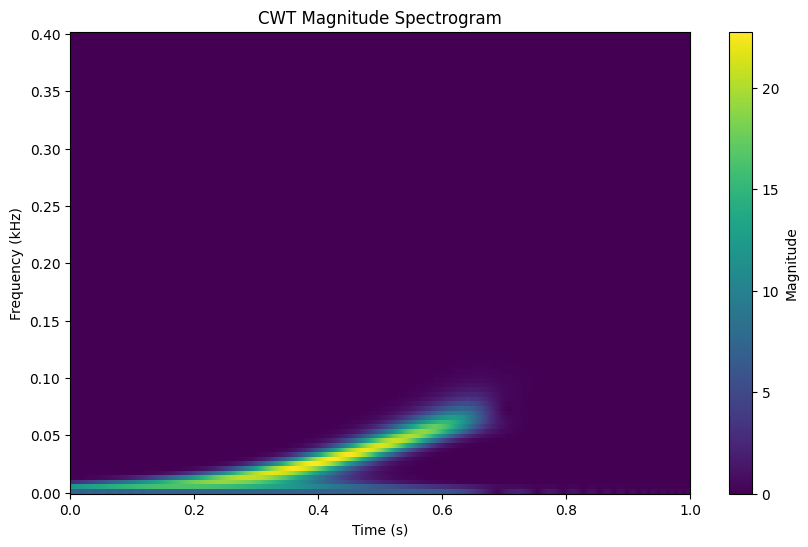

In [21]:
cwt_matrix=cwt_proof.calculate()
cwt_proof.plot(cwt_matrix)

In [25]:
#celda para crear la lista con los paths de mi data
paths=[] #creo la lista de pahts
names=[] #creo la lista de nombres
output_file=[]
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/vibration_1')
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part1')
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part2')
paths.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part3')
names.append('vibration')
names.append('part1')
names.append('part2')
names.append('part3')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/vibration_1/vibration')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part1/part1')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part2/part2')
output_file.append('/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/part3/part3')


Available files:
1. vibration_ball_5
2. vibration_ball_6
3. vibration_inner_5
4. vibration_inner_6
5. vibration_normal_5
6. vibration_normal_6
7. vibration_outer_5
8. vibration_outer_6
Enter the index of the file you want to plot: 1


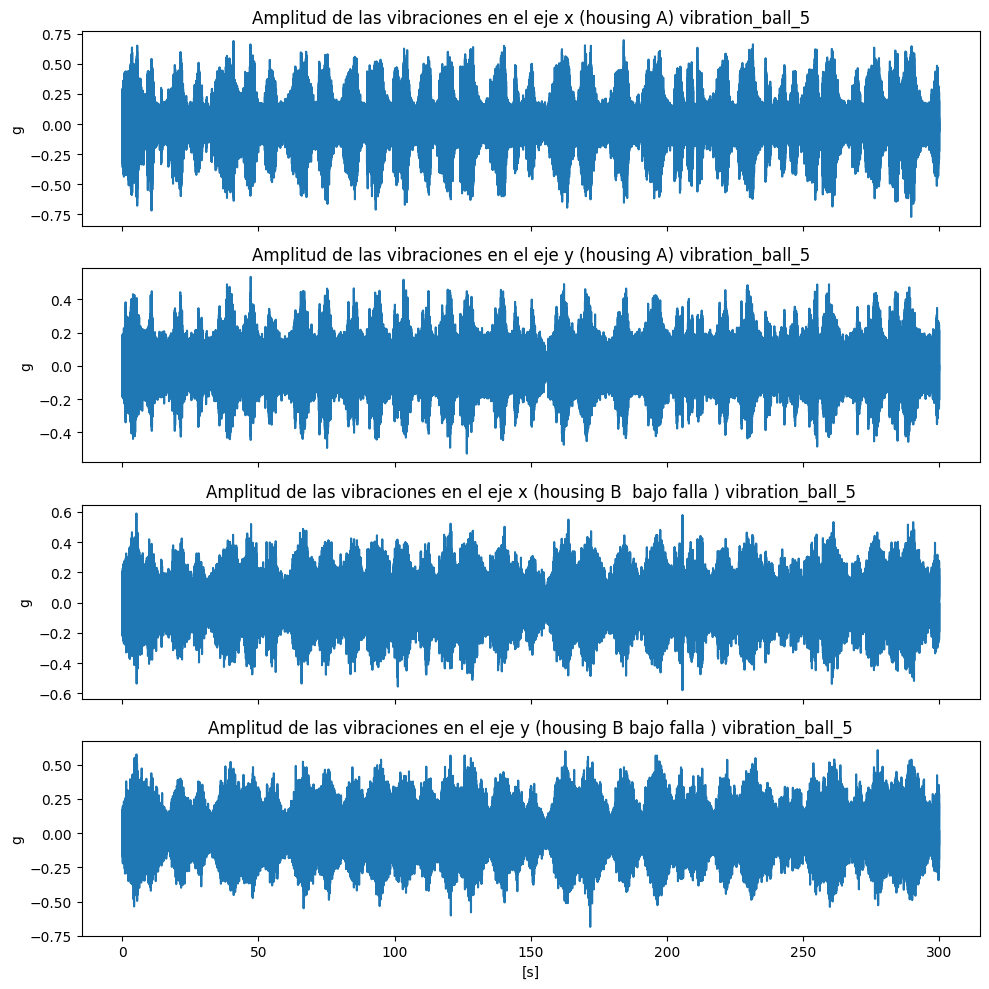

In [31]:
# h5py_file =output_file[1]
graficador.plot_data_from_h5py(output_file[3])